In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [210]:
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_rows = 500

The main goal from this notebook is to invent new features similar to what we did with `total_distance` in the main EDA. We will start by adding that feature to make sure the new features we add do not make any multicolinearity issues.

In [211]:
df = pd.read_csv("../data/split/train.csv")
df["trip_duration"] = np.log1p(df["trip_duration"])  # What we want to predict

In [212]:
# Using distance formula:
# https://www.chegg.com/homework-help/questions-and-answers/point-latitude-373198-point-longitude-121936-point-b-latitude-373185-point-b-longitude-121-q56508606

R = 6356  # radius of Earth in km

# Convert degrees to radians
lat1 = np.radians(df["pickup_latitude"])
lat2 = np.radians(df["dropoff_latitude"])
lon1 = np.radians(df["pickup_longitude"])
lon2 = np.radians(df["dropoff_longitude"])

# x and y components of distance
x = R * (lat1 - lat2)
y = R * (lon1 - lon2) * np.cos(lat2)

# Euclidean distance approximation
df["trip_distance"] = np.sqrt(x**2 + y**2)

In [213]:
def clean_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 5 * iqr
    upper_bound = q3 + 5 * iqr
    
    df_no_outliers = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df_no_outliers

In [214]:
df["trip_distance"] = np.log1p(df["trip_distance"])
df = clean_outliers(df, "trip_distance")

In [ ]:
df["coord_sum"] = df["dropoff_latitude"] + df["dropoff_longitude"] + df["pickup_latitude"] + df["pickup_longitude"]
df["coord_square_sum"] = df["dropoff_latitude"]**2 + df["dropoff_longitude"]**2 + df["pickup_latitude"]**2 + df["pickup_longitude"]**2



In [216]:
# dropping coordinates to avoid any multicolinearity issues with the created features
df.drop("dropoff_latitude", axis=1, inplace=True)
df.drop("dropoff_longitude", axis=1, inplace=True)
df.drop("pickup_latitude", axis=1, inplace=True)
df.drop("pickup_longitude", axis=1, inplace=True)

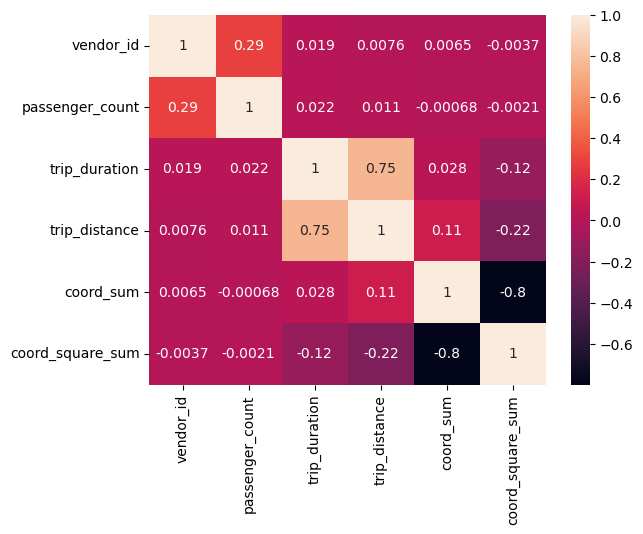

In [217]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()

As a starting point, the correlation between `vendor_id` and `passenger_count` seems to be interesting. It probably means that one vendor used to take more passengers then the other vendor.

In [218]:
# df.drop("vendor_id", axis=1, inplace=True)

In [219]:
df.loc[:, 'store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'Y':0})
df.loc[:, 'store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'N':1})
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('int')

/tmp/ipykernel_366341/89604162.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, 'store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'N':1})


In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dayofweek'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month
df['hour'] = df.pickup_datetime.dt.hour
df['dayofyear'] = df.pickup_datetime.dt.dayofyear

df["isNight"] = df["hour"] // 18
df["isWeekend"] = df.pickup_datetime.dt.weekday // 5

In [221]:
df["isNight"].value_counts()

isNight
0    657782
1    342210
Name: count, dtype: int64

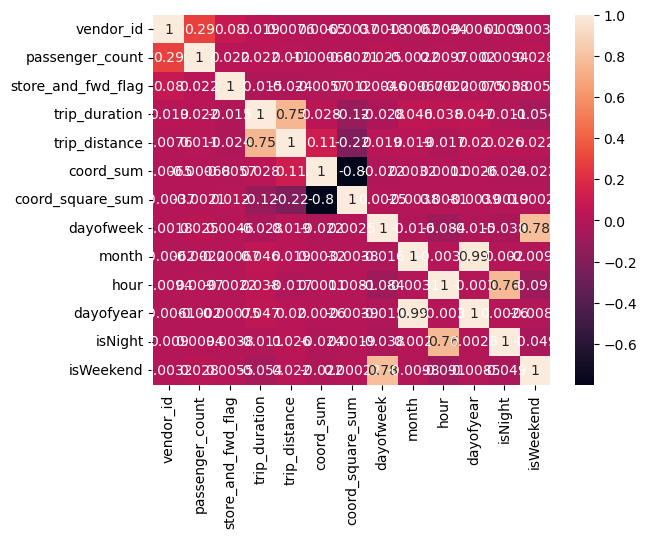

In [222]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()

We see that dayofyear and month features are highly correlated, and this is because dayofyear
is mainly calculated using the months before it using a linear equation, so it is better to remove 
one of these features as they are linearly correlated.

In [223]:
df.drop("dayofyear", axis=1, inplace=True)

Now, since taxi drivers in NYC can pickup multiple passengers at once then we can calculate the approximate distance per passenger to use it as a separate feature.

In [224]:
df = df[(df["passenger_count"] != 0) & (df["passenger_count"] != 7)]  # first we remove outliers
df["distance_per_passenger"] = df["trip_distance"] / (df["passenger_count"])

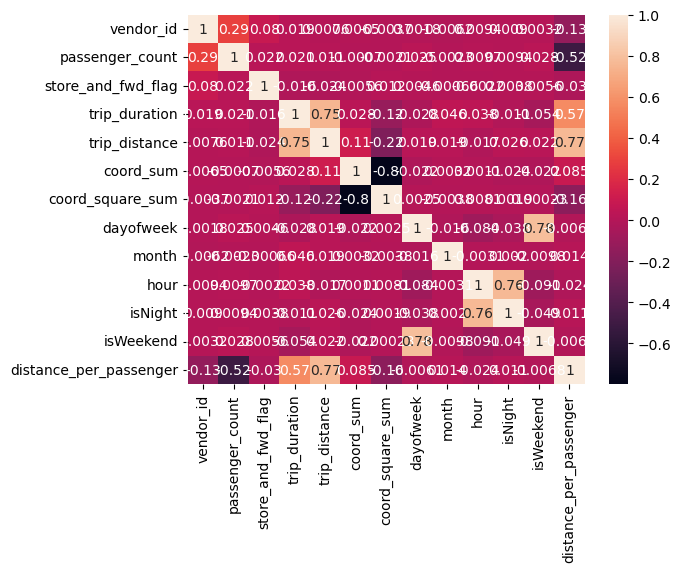

In [225]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)
plt.show()